In [380]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from typing import Dict, List, Set
import numpy as np
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [381]:
locations_synonyms: Dict[str, List[str]] = {
    "Warszawa": ["Warsaw", "Warszawa", "Katowice; Warszawa", "Warszawa (Centrum)", "Waraszawa"],
    "Kraków": ["Krakow", "Kraków"],
    "Wrocław": ["Wroclaw", "Wrocław"],
    "Poznań": ["Poznan", "Poznań", "Pozanań"],
    "Gdańsk": ["Gdansk", "Gdańsk"],
    "Szczecin": ["Szczecin", "szczecin"],
    "Łódź": ["Lodz", "Łódź"],
    "Rzeszów": ["Rzeszow", "Rzeszów"],
    "Katowice": ["Katowice", "Katowice; Warszawa"],
    "Kielce": ["Kielce"],
    "Opole": ["opole", "Opole"],
    "Sopot": ["Sopot"],
    "Olszytn": ["Olsztyn"],
    "Gdynia": ["Gdynia"],
}

location_encoder = LabelEncoder()
exp_encoder = LabelEncoder()
mode_encoder = LabelEncoder()

# read data from json file
df = pd.read_json("../data/offers.json")

def replace_synonyms(locations):
    for standard, synonyms in locations_synonyms.items():
        for i, loc in enumerate(locations):
            if loc in synonyms:
                locations[i] = standard
    return locations

df["locations"] = df["locations"].apply(replace_synonyms)
df = df.explode("locations")
df["location"] = df["locations"]

df["location_code"] = location_encoder.fit_transform(df["location"])

df["experience_code"] = exp_encoder.fit_transform(df["experience"])
df["operating_mode_code"] = mode_encoder.fit_transform(df["operating_mode"])
df = df.drop(columns=["locations", "operating_mode", "experience", "location"])

mlb = MultiLabelBinarizer()

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('technologies')),
                          columns=mlb.classes_,
                          index=df.index))

df.to_csv("../data/offers_normalized_locations.csv", index=False)    


## Usuwanie niepotrzebnych danych

Na wszelki wypadek usuwam niepotrzebne dane, które mogą być niepotrzebne w przyszłości.
<p style="color: red">W przypadku ofert pracy gdzie nie ma definiowanych widełek dla np. b2b nie będę ich próbował wyliczać, bo nie ma to sensu, ponieważ zarobki zależą od technologi i poziomu doświadczenia.</p> 


In [382]:
offers = pd.read_csv("../data/offers_normalized_locations.csv")

offers = offers.drop_duplicates()
offers = offers.dropna()

rows_to_drop = offers[((offers['max_uop'] < 1000) & (offers["max_uop"] > 0)) | ((offers['max_b2b'] < 1000) & (offers["max_b2b"] > 0))].index
offers = offers.drop(rows_to_drop)

offers.columns = offers.columns.str.strip()

offers.to_csv("../data/jobs.csv", index=False)

## Zapis i naprawa danych z formatu JSON do CSV.

Na początku tworze sobie synonimy dla najpopularniejszych nazw miast, ponieważ w niektórych przypadkach, 
miasta mają w sobie literówki np. `Waraszawa` albo nie obsłużyłem wystarczająco dużo przypadków przy miastach.
Następnie naprawiamy sobie lokacje oraz technologie. W przypadku technologii nie naprawam ich ponieważ mam pewność że są poprawne przez to ze były w jednym miejscu na stronie oraz po przejrzeniu ich nie znalazłem błędów.

# Szybki look na dane

In [383]:
data = pd.read_csv('../data/jobs.csv')
df = pd.DataFrame(data)
# title,min_b2b,max_b2b,min_uop,max_uop,experience,operating_mode,experience_code,operating_mode_code
display(df.head())

,title,min_b2b,max_b2b,min_uop,max_uop,location_code,experience_code,operating_mode_code,AWS,Angular,...,React,Ruby,SQL,Scala,Spring,Terraform,TypeScript,Vue.js,Windows,android
0,Senior Software Engineer - Full Stack (JavaScr...,0,0,18000,28000,51,2,0,1,0,...,1,0,0,0,0,1,1,0,0,0
1,Senior Backend Node.js Engineer (remote),0,0,18360,25125,38,2,2,0,0,...,1,0,0,0,0,0,1,0,0,0
2,Senior Backend Node.js Engineer (remote),0,0,18360,25125,17,2,2,0,0,...,1,0,0,0,0,0,1,0,0,0
3,Senior Backend Node.js Engineer (remote),0,0,18360,25125,51,2,2,0,0,...,1,0,0,0,0,0,1,0,0,0
4,Senior Backend Node.js Engineer (remote),0,0,18360,25125,55,2,2,0,0,...,1,0,0,0,0,0,1,0,0,0


In [384]:
print(len(df))

4574


# Średnie zarobki na b2b dla juniora

In [385]:
df[(df["min_b2b"] > 0) & (df["max_b2b"] > 0)].iloc[:, :3].describe().round(2)


,min_b2b,max_b2b
count,3890.00,3890.00
mean,19139.54,25577.15
std,6277.14,7459.57
min,2349.00,3916.00
25%,15000.00,20505.00
50%,19200.00,25225.00
75%,23499.00,30000.00
max,45000.00,60000.00


In [386]:
df[(df["min_uop"] > 0) & (df["max_uop"] > 0)].iloc[:, 3:5].describe().round(2)

,min_uop,max_uop
count,1853.00,1853.00
mean,16198.06,22594.73
std,5879.03,8306.24
min,4250.00,6000.00
25%,12000.00,17000.00
50%,15000.00,21000.00
75%,19100.00,26000.00
max,40000.00,80000.00


# Zarobki na kontrakcie B2B 

In [387]:
exp_code = df["experience_code"].value_counts().index
exp_name = exp_encoder.inverse_transform(exp_code)

for name in exp_name:
    code = exp_encoder.transform([name])[0]
    print(f"Experience: {name}")
    print(df[(df["experience_code"] == code) & (df["min_b2b"] > 0) & (df["max_b2b"] > 0)].iloc[:, :3].describe().round(2))
        

Experience: Senior
        min_b2b   max_b2b
count   2298.00   2298.00
mean   22297.60  29136.52
std     5271.13   6605.39
min     7833.00  11749.00
25%    19000.00  25000.00
50%    22000.00  28500.00
75%    25200.00  32000.00
max    45000.00  60000.00
Experience: Mid
        min_b2b   max_b2b
count   1491.00   1491.00
mean   15055.68  20995.32
std     4317.57   4951.93
min     2349.00   3916.00
25%    12000.00  18000.00
50%    15000.00  21000.00
75%    17000.00  25000.00
max    30000.00  37000.00
Experience: Junior
        min_b2b   max_b2b
count    101.00    101.00
mean    7573.17  12231.19
std     1848.20   3524.61
min     4400.00   6000.00
25%     6306.00  10000.00
50%     7833.00  11000.00
75%     8000.00  14000.00
max    14000.00  22000.00


In [388]:
exp_code = df["experience_code"].value_counts().index
exp_name = exp_encoder.inverse_transform(exp_code)

for name in exp_name:
    code = exp_encoder.transform([name])[0]
    print(f"Experience: {name}")
    print(df[(df["experience_code"] == code) & (df["min_uop"] > 0) & (df["max_uop"] > 0)].iloc[:, 3:5].describe().round(2))
        

Experience: Senior
        min_uop   max_uop
count   1114.00   1114.00
mean   18930.61  25848.46
std     5665.84   8563.28
min     8000.00  11000.00
25%    15000.00  20000.00
50%    18300.00  24500.00
75%    22000.00  30000.00
max    40000.00  80000.00
Experience: Mid
        min_uop   max_uop
count    681.00    681.00
mean   12378.99  18041.77
std     2888.90   4440.94
min     5000.00   7000.00
25%    10000.00  15000.00
50%    13000.00  17000.00
75%    14000.00  20750.00
max    25000.00  30000.00
Experience: Junior
        min_uop   max_uop
count     58.00     58.00
mean    8555.40  13558.71
std     4120.82   6074.08
min     4250.00   6000.00
25%     5125.00   8250.00
50%     8000.00  11500.00
75%     9000.00  20125.00
max    16443.00  28000.00


# Tworzymy histogramy

Proponuje następujące rozkłady:
- typu pracy
- doświadczenia
- zarobków
- technologii
- lokalizacji


Zacznijmy od napisania funkcji która będzie tworzyć histogramy dla każdej z tych kategorii.

In [389]:
import pandas as pd
import matplotlib.pyplot as plt

def get_histogram(data, column_name, title, encoder, label_x="", label_y="", is_specified=False, exp=None):
    if is_specified:
        exp_code = exp_encoder.transform([exp])[0]
        print(f"Experience: {exp_code}")
        data = data[data["experience_code"] == exp_code]
    # Zliczanie unikalnych wartości w kolumnie
    value_counts = data[column_name].value_counts().head(12)
    
    # Dekodowanie kodów na nazwy
    location_names = encoder.inverse_transform(value_counts.index)
    value_counts.index = location_names
    print(value_counts)
    
    # Tworzenie wykresu kołowego
    plt.figure(figsize=(8, 8))
    value_counts.plot(kind='pie', autopct='%1.1f%%')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"plots/rozkłady/{title.lower().replace(" ", "_")}.png")
    plt.show()



In [390]:
def compute_amount_offers_for(exp):
    exp_code = exp_encoder.transform([exp])[0]
    offers_amount = df['experience_code'].value_counts()[exp_code]
    print(f"Liczba ofert pracy dla {exp}:", offers_amount)
    return offers_amount
    
mid_offers = compute_amount_offers_for("Mid")
senior_offers  = compute_amount_offers_for("Senior")
junior_offers =  compute_amount_offers_for("Junior")

assert mid_offers + senior_offers + junior_offers == len(df)

Liczba ofert pracy dla Mid: 1766
Liczba ofert pracy dla Senior: 2669
Liczba ofert pracy dla Junior: 139


## Histogram typu pracy

Remote    3818
Hybrid     635
Office     121
Name: count, dtype: int64


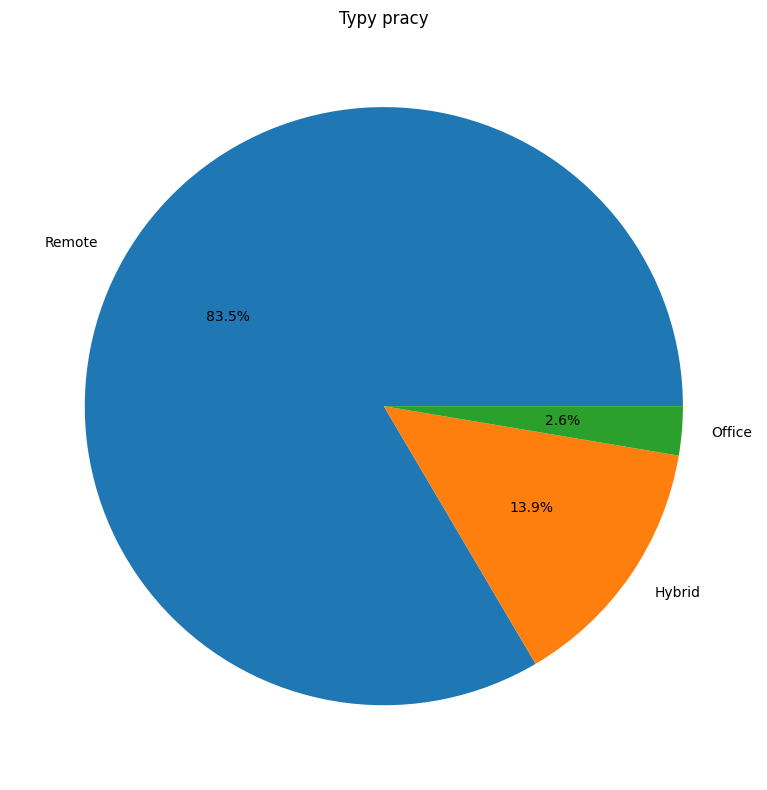

In [391]:
get_histogram(df, 'operating_mode_code', 'Typy pracy', encoder=mode_encoder)

## Histogram doświadczenia

Senior    2669
Mid       1766
Junior     139
Name: count, dtype: int64


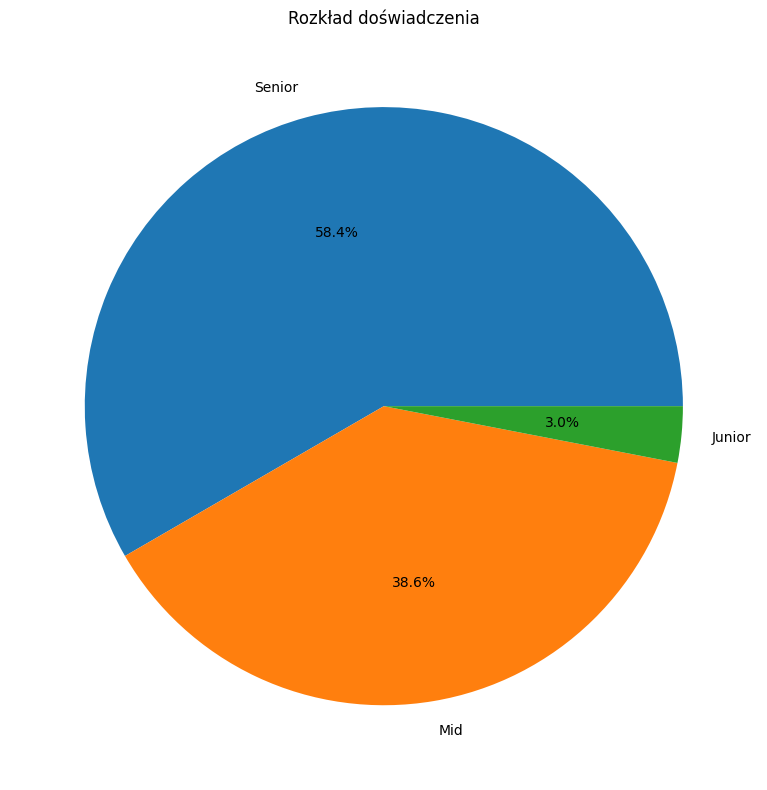

In [392]:
get_histogram(df, 'experience_code', title="Rozkład doświadczenia", label_x="", label_y="", encoder=exp_encoder)

# Rozkład zarobków na B2B

In [393]:
def salary_distribution(data, exp, encoder=exp_encoder, color='skyblue'):
    exp_code = encoder.transform([exp])[0]
    df_filtered_b2b = data[(data["min_b2b"] > 0) & (data["max_b2b"] > 0) & (data["experience_code"] == exp_code)].copy()

    print(f"Rozkład wynagrodzeń dla {exp}, liczba ofert z b2b: {len(df_filtered_b2b)}")

    df_filtered_b2b['avg_b2b'] = df_filtered_b2b[["min_b2b", "max_b2b"]].mean(axis=1)

    plt.figure(figsize=(20, 6))  # Adjust the size to accommodate two plots

    plt.subplot(1, 2, 1) # layout 
    sns.kdeplot(df_filtered_b2b['avg_b2b'], color=color)
    plt.title(f"Rozkład zarobków {exp}a na B2B")
    plt.xlabel(f"Średnie wynagrodzenie {exp}a na B2B")
    plt.ylabel("Gęstość ofert")
    plt.grid(True)

    df_filtered_uop = data[(data["min_uop"] > 0) & (data["max_uop"] > 0) & (data["experience_code"] == exp_code)].copy()
    print(f"Rozkład wynagrodzeń dla {exp}, liczba ofert z uop: {len(df_filtered_uop)}")
    df_filtered_uop['avg_uop'] = df_filtered_uop[["min_uop", "max_uop"]].mean(axis=1)

    # drugi
    plt.subplot(1, 2, 2)
    sns.kdeplot(df_filtered_uop['avg_uop'], color=color)
    plt.title(f"Rozkład zarobków {exp}a na UOP")
    plt.ylabel("Gęstość ofert")
    plt.xlabel(f"Średnie wynagrodzenie {exp}a na UOP")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/rozkłady/pensje_dla_{exp.lower()}a.png")
    plt.show()


Rozkład wynagrodzeń dla Mid, liczba ofert z b2b: 1491
Rozkład wynagrodzeń dla Mid, liczba ofert z uop: 681


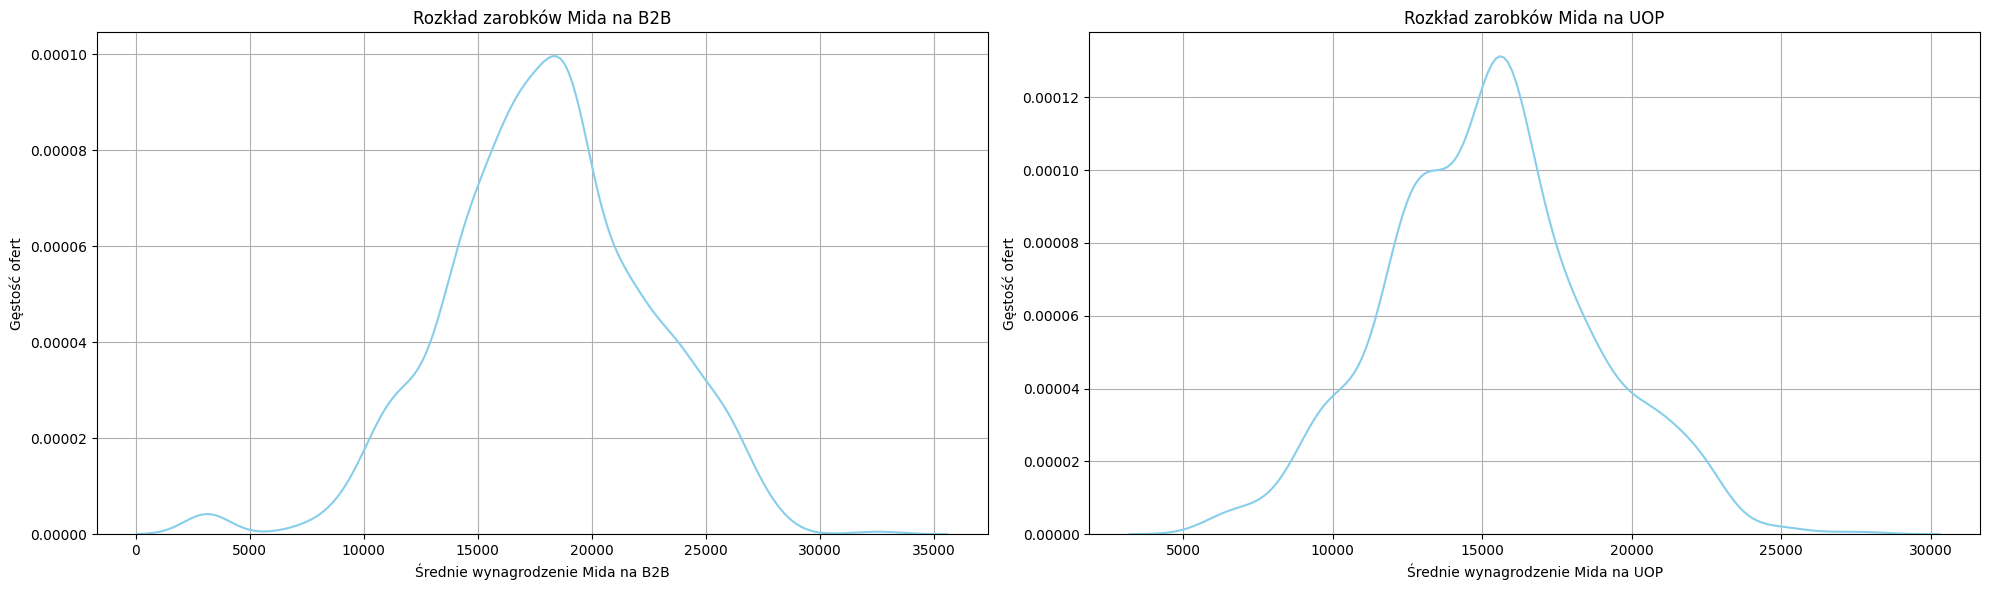

Rozkład wynagrodzeń dla Senior, liczba ofert z b2b: 2298
Rozkład wynagrodzeń dla Senior, liczba ofert z uop: 1114


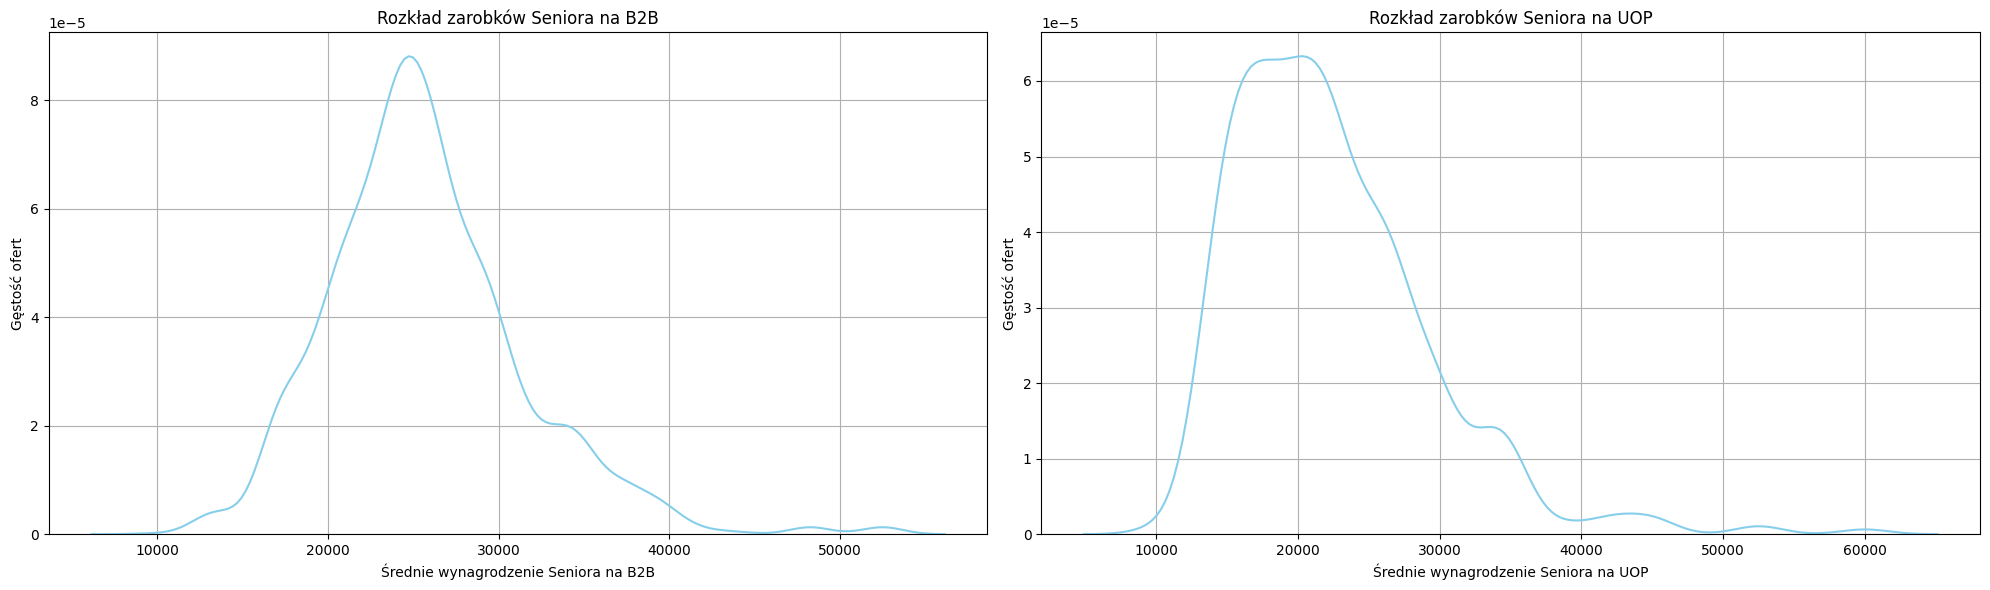

Rozkład wynagrodzeń dla Junior, liczba ofert z b2b: 101
Rozkład wynagrodzeń dla Junior, liczba ofert z uop: 58


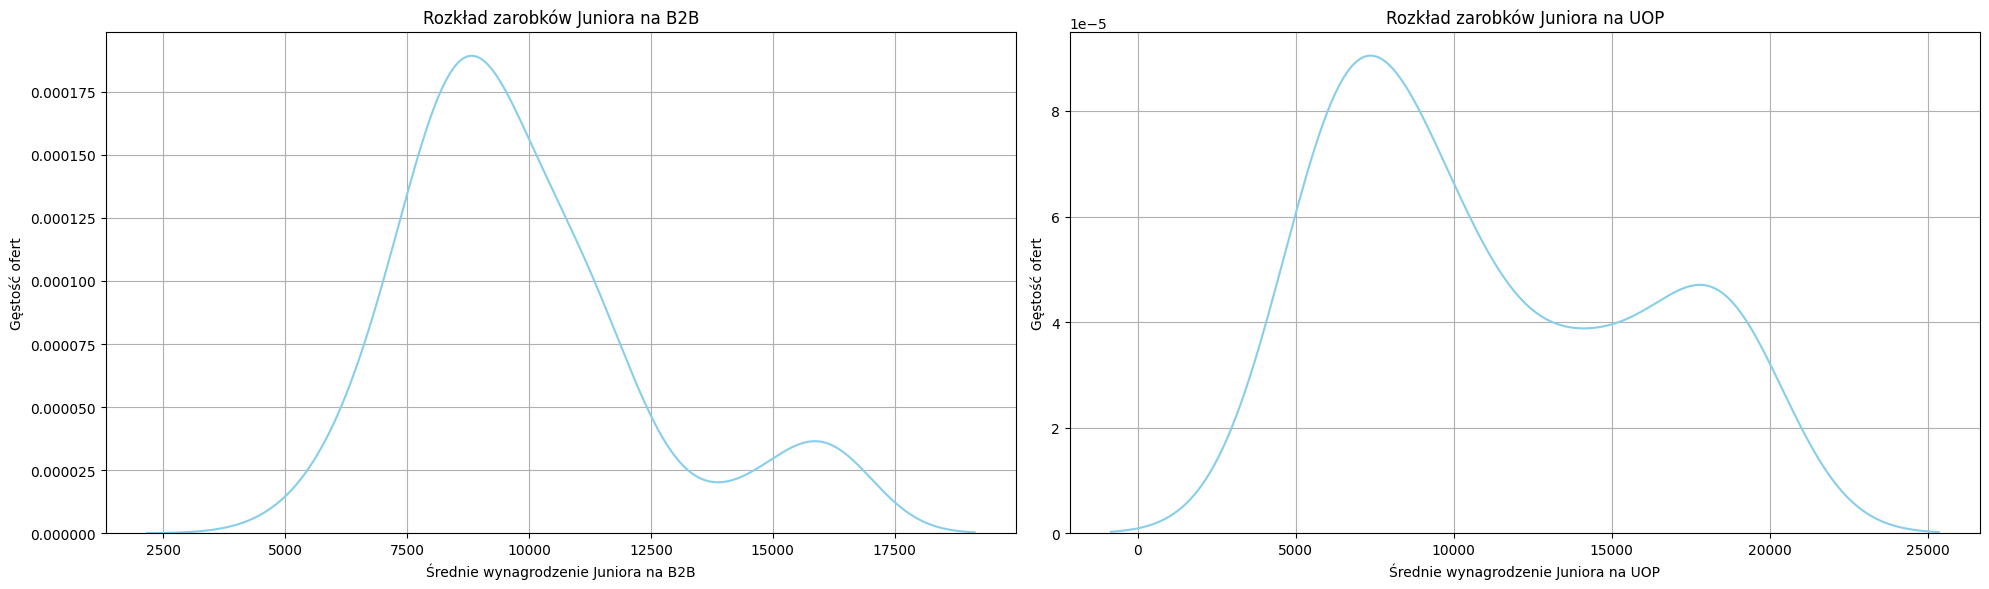

In [394]:
salary_distribution(df, "Mid")
salary_distribution(df, "Senior")
salary_distribution(df, "Junior")

# Rozkład popularności technologii

In [395]:
def popularity(data, start_column, end_column, title, xlabel, ylabel, figsize=(22, 6), color='blue'):
    technologies = data.loc[:, start_column:end_column]

    sum_of_tech = technologies.sum().sort_values(ascending=False)

    plt.figure(figsize=figsize)
    sum_of_tech.plot(kind='bar', color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/rozkłady/{title.lower().replace(" ", "_")}.png")
    plt.show()


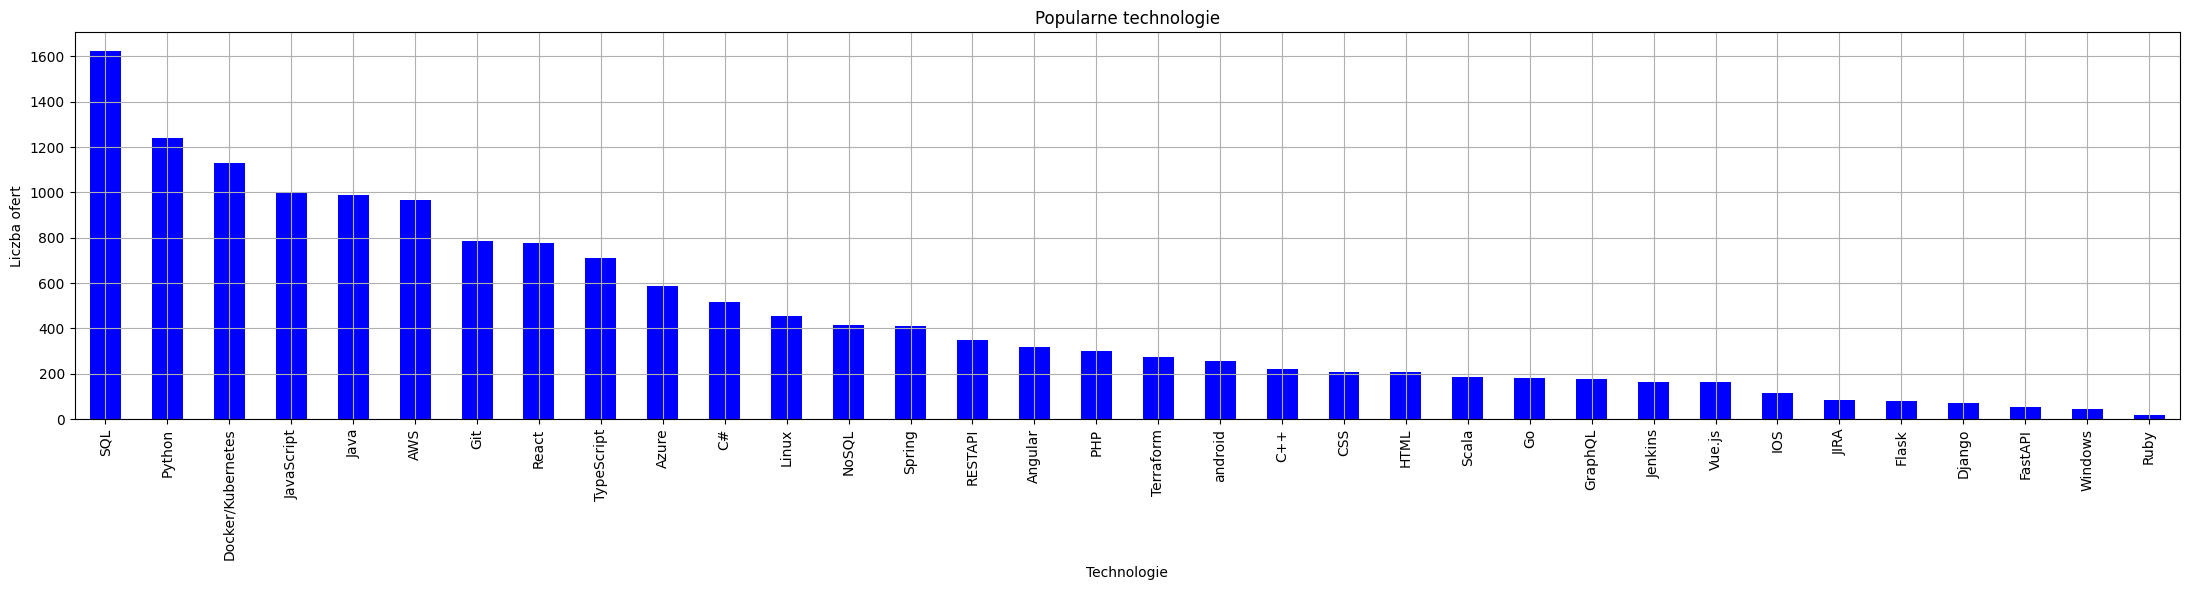

In [396]:
popularity(df, 'AWS', 'android', 'Popularne technologie', 'Technologie', 'Liczba ofert')

# Rozkład lokalizacji

Warszawa     827
Kraków       658
Wrocław      597
Gdańsk       494
Poznań       489
Katowice     327
Łódź         279
Rzeszów      191
Lublin       172
Bydgoszcz    116
Białystok     99
Toruń         68
Name: count, dtype: int64


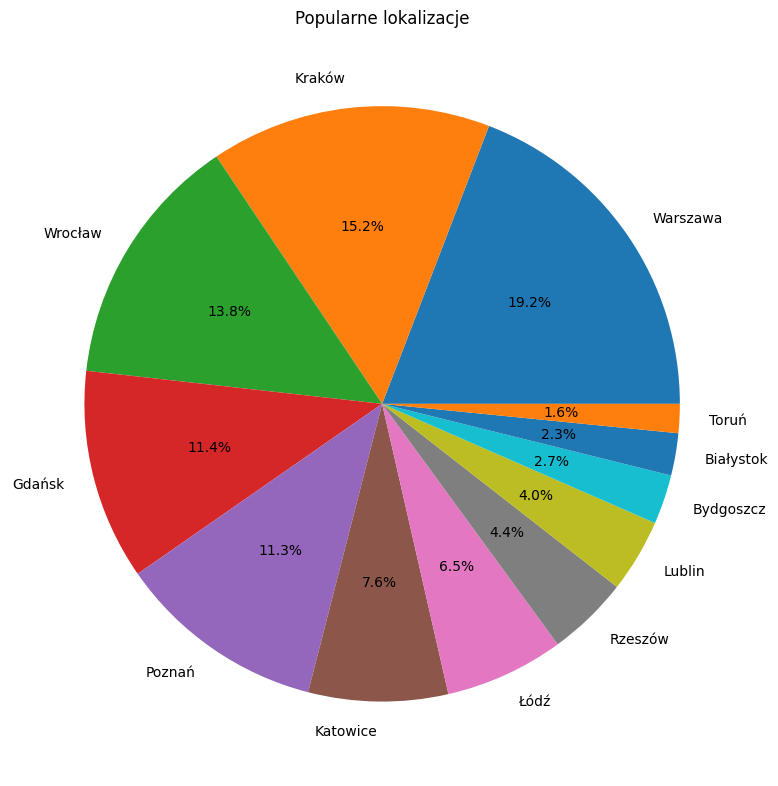

In [397]:
get_histogram(df, 'location_code', 'Popularne lokalizacje', location_encoder, label_x="", label_y="")

Experience: 0
Warszawa     27
Wrocław      20
Katowice     15
Kraków       15
Gdańsk       14
Poznań       14
Łódź          6
Rzeszów       6
Toruń         5
Gliwice       5
Lublin        3
Białystok     2
Name: count, dtype: int64


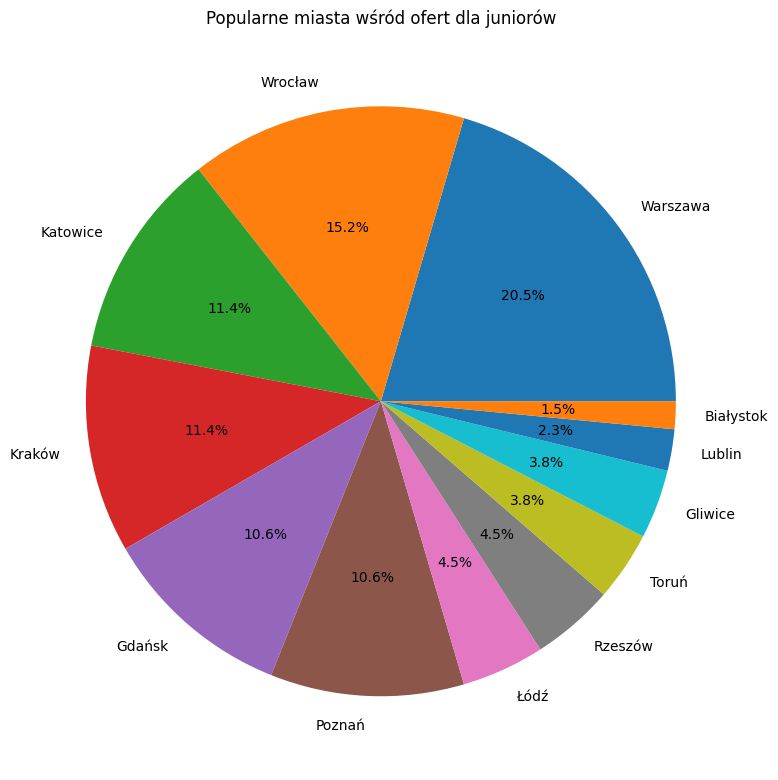

In [398]:
get_histogram(df, 'location_code', 'Popularne miasta wśród ofert dla juniorów', location_encoder, label_x="", label_y="", is_specified=True, exp="Junior")

# Macierz korelacji techonlogii

Czy jakieś techonologie idą ze sobą w parze.


In [399]:
def create_corr_plot(corr, title, size=(20,20)):
    plt.figure(figsize=size)
    sns.heatmap(corr, annot=True,fmt=".2f", linecolor="lightgrey", linewidths=0.5, cmap="flare")
    sns.color_palette("flare", as_cmap=True)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"plots/korelacje/{title.lower().replace(" ", "_")}.png")
    plt.show()

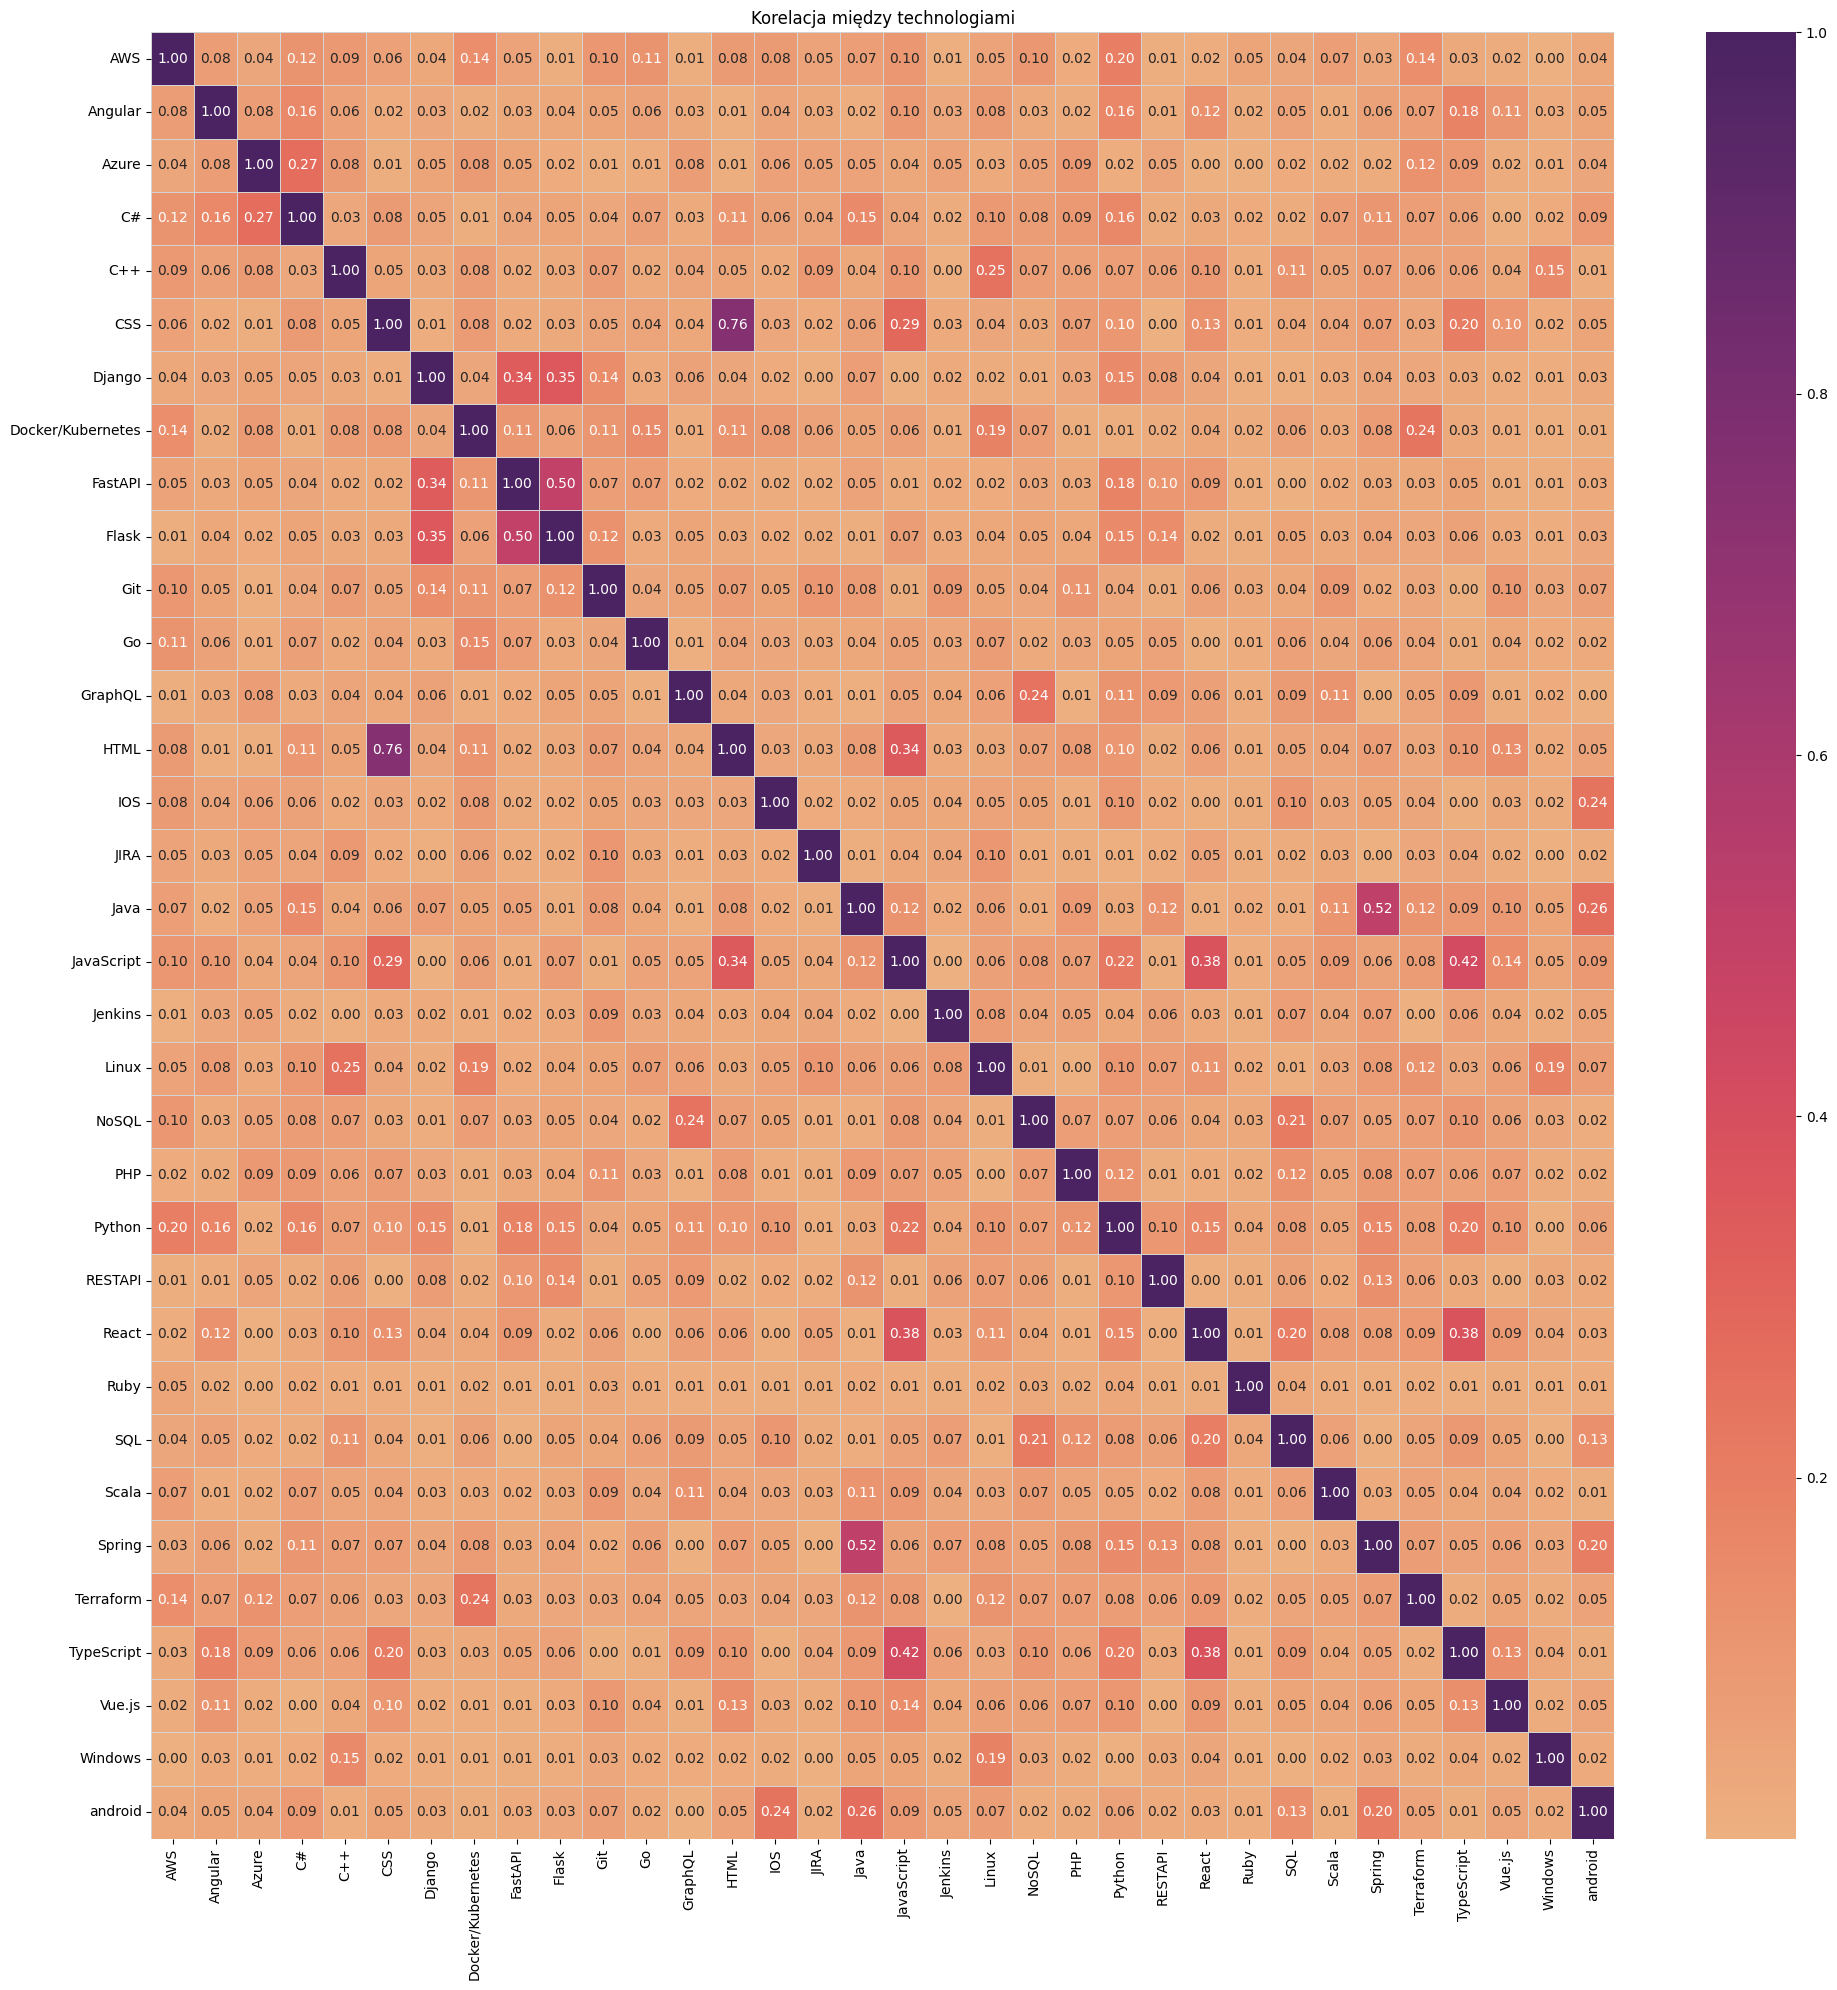

In [400]:
# Obliczenie korelacji między wybranymi kolumnami
technologies = df.loc[:, "AWS": "android"].columns.tolist()
corr = df[technologies].corr()
corr = corr.abs()
create_corr_plot(corr, 'Korelacja między technologiami')


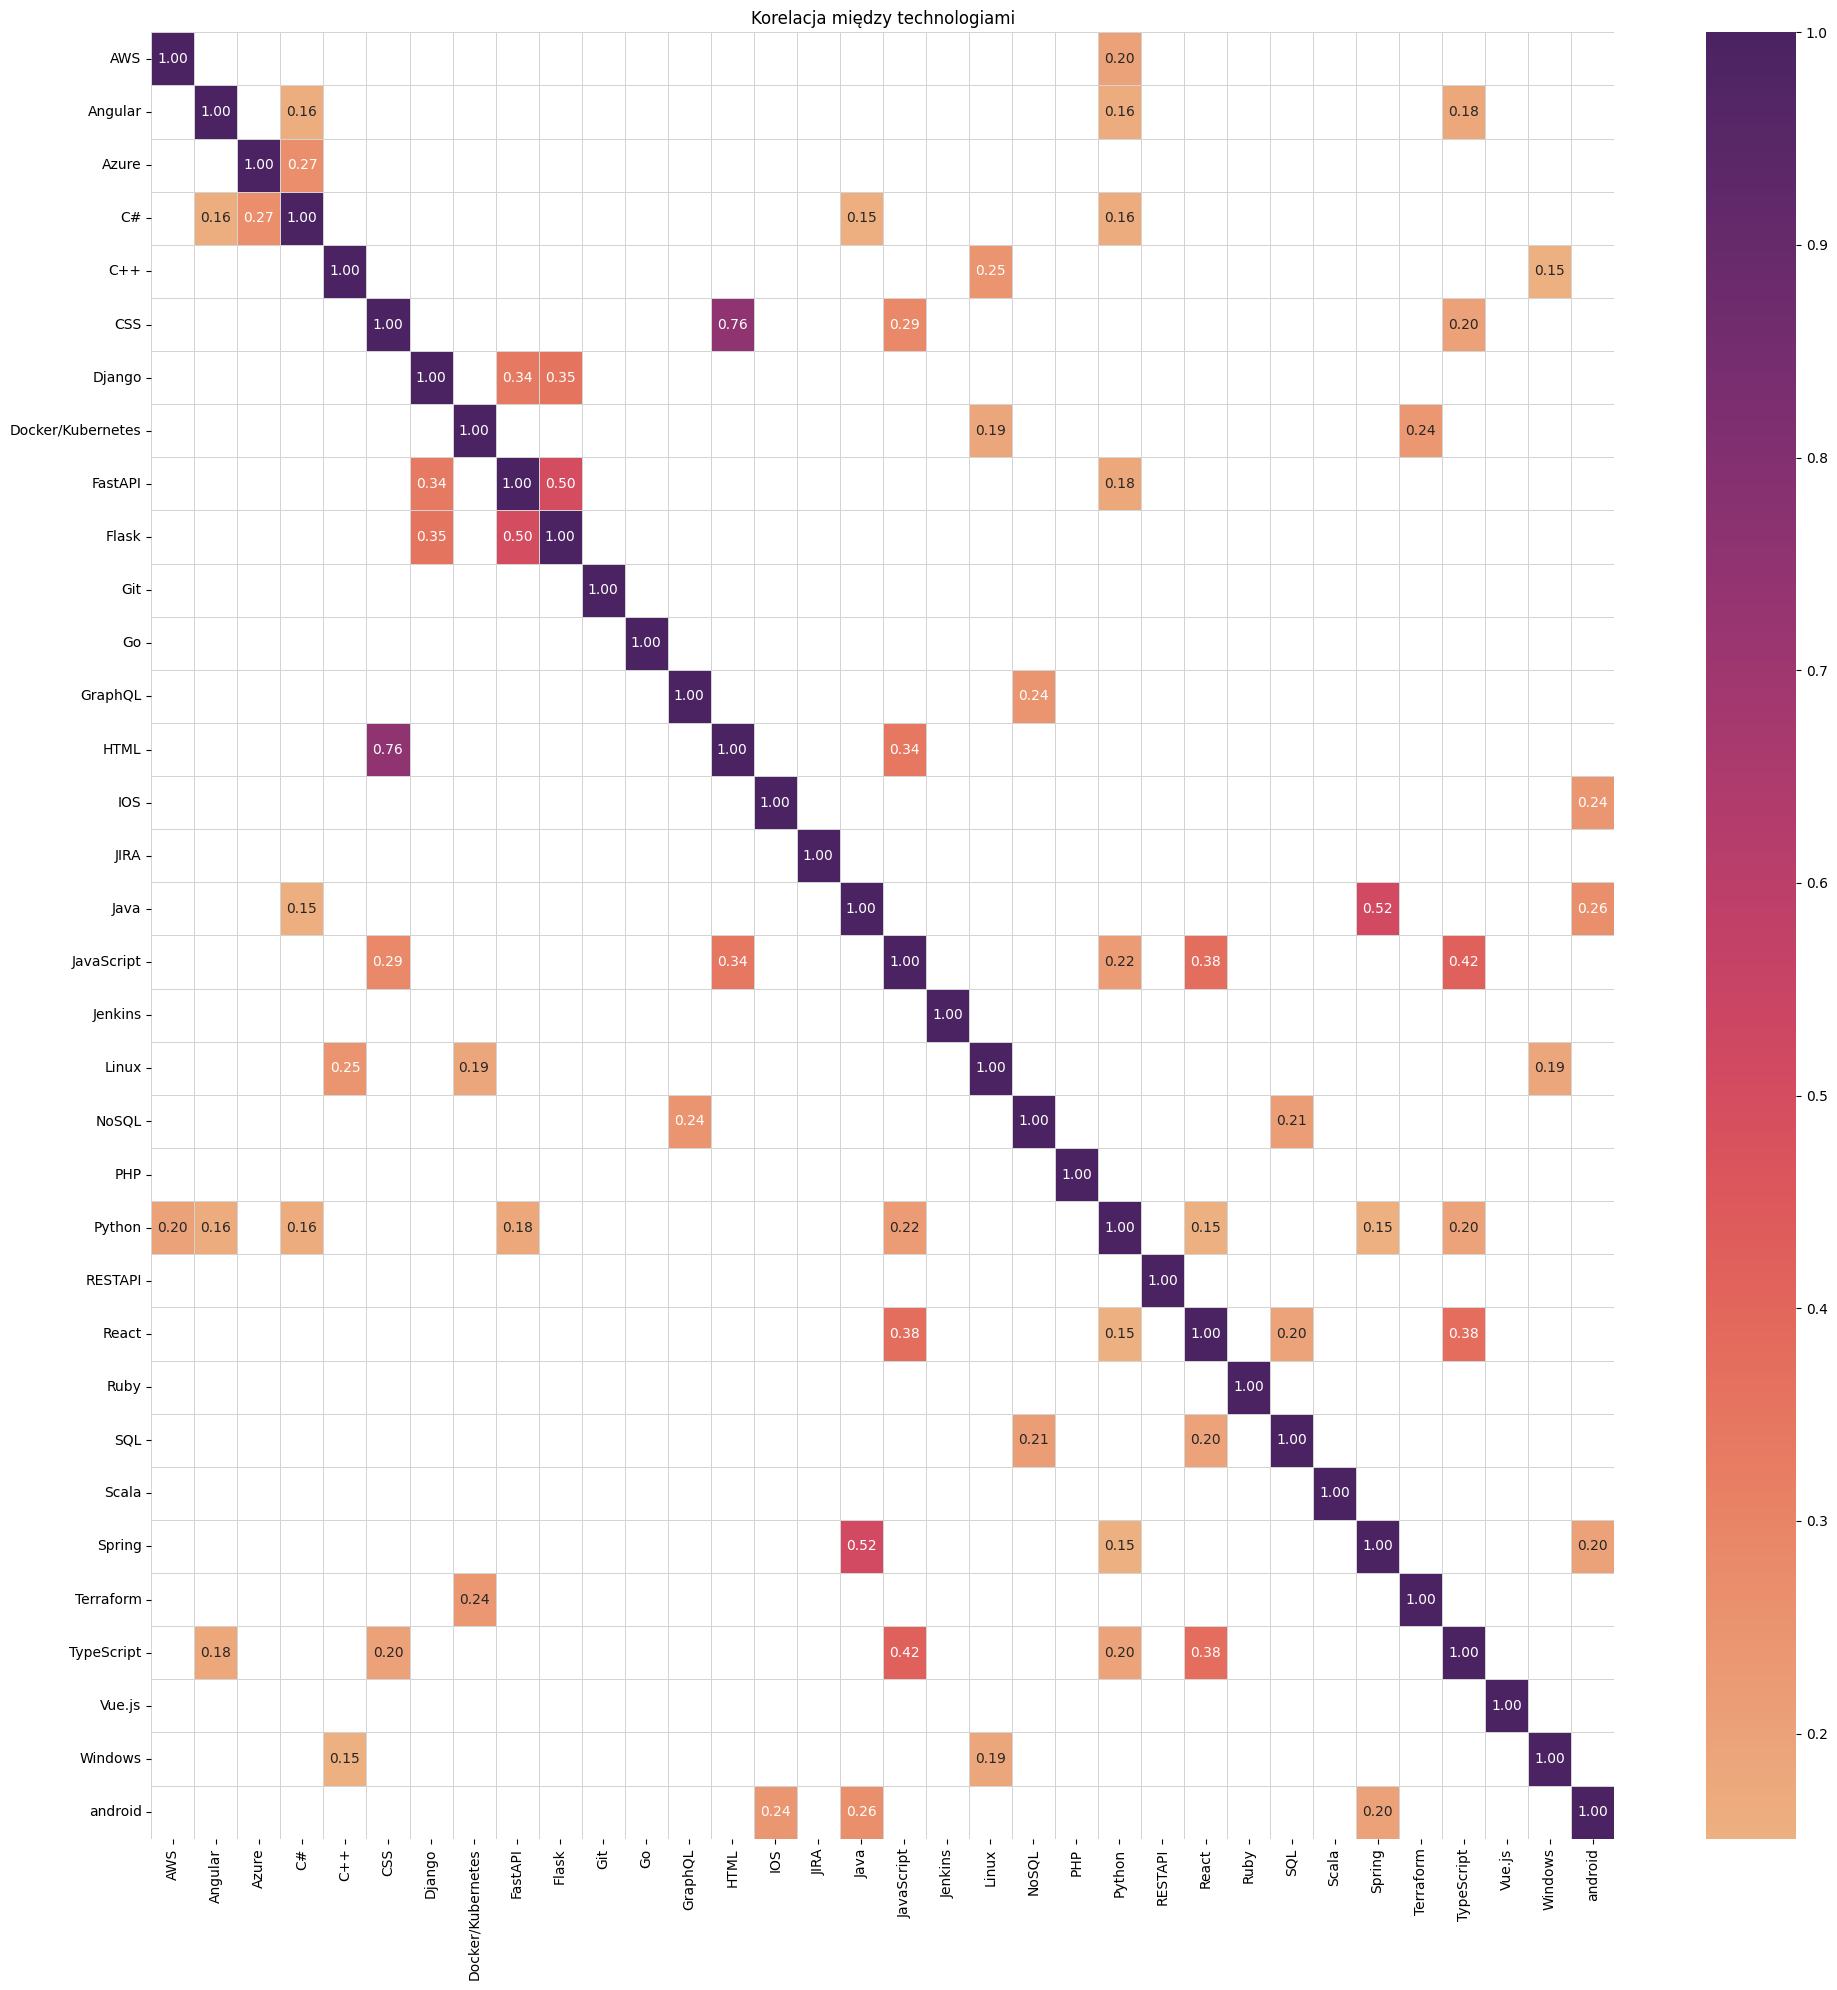

In [401]:
technologies = df.loc[:, "AWS": "android"].columns.tolist()
corr_matrix = df[technologies].corr().abs()

mask = corr_matrix > 0.15

filtered_corr = corr_matrix[mask]

create_corr_plot(filtered_corr, 'Korelacja między technologiami')

# Macierz korelacji wybranych zmiennych

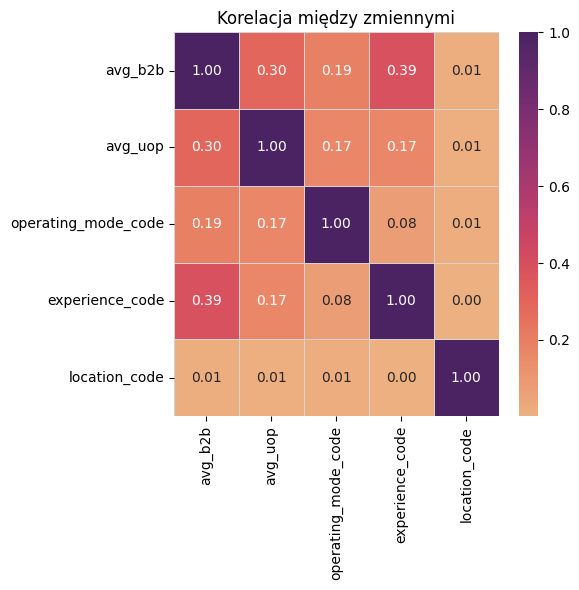

In [402]:
data["avg_b2b"] = data[["min_b2b", "max_b2b"]].mean(axis=1)
data["avg_uop"] = data[["min_uop", "max_uop"]].mean(axis=1)

vars = ["avg_b2b", "avg_uop", "operating_mode_code", "experience_code", "location_code"]

corr = data[vars].corr()
corr = corr.abs()

create_corr_plot(corr, 'Korelacja między zmiennymi', size=(6,6))



# Zarobki a technologie

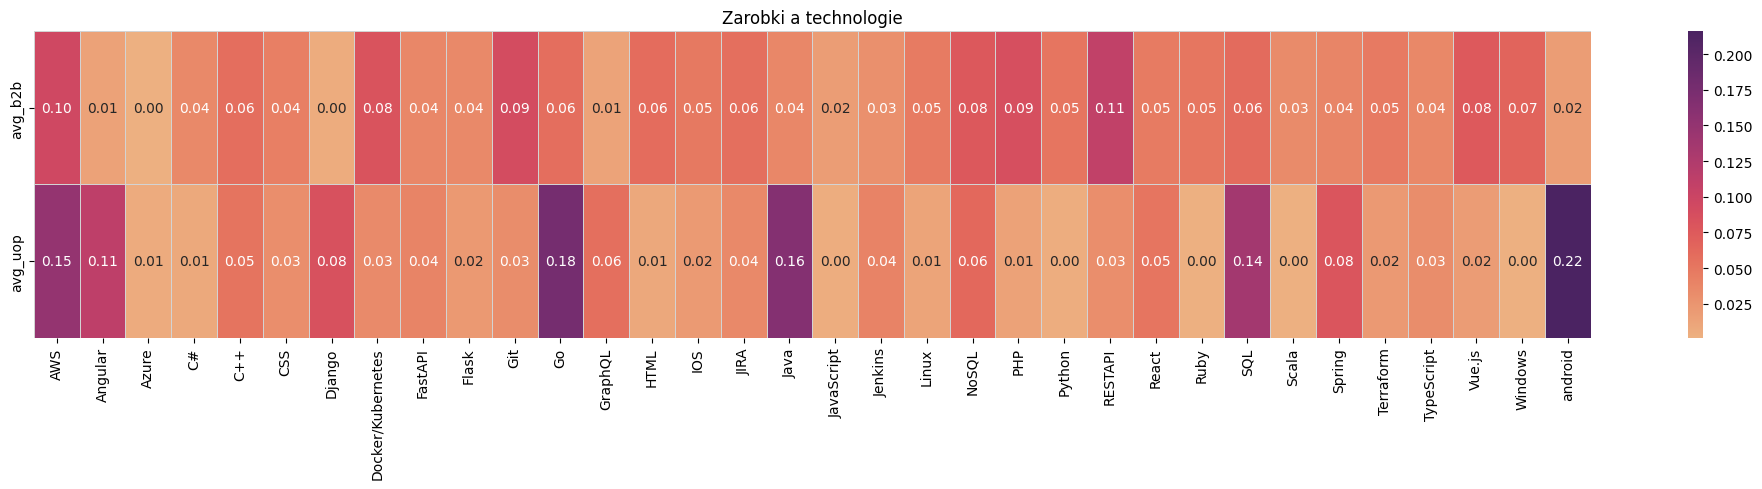

In [403]:
salaries = ["avg_b2b", "avg_uop"]
techs = data.loc[:, "AWS":"android"]

all_vars = salaries + list(techs.columns)
corr = data[all_vars].corr()
corr = corr.abs()  
corr = corr.loc[salaries, techs.columns] 

create_corr_plot(corr, "Zarobki a technologie", size=(20, 5))



# Korelacja technologii a lokalizacji

/tmp/ipykernel_5052/584414074.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


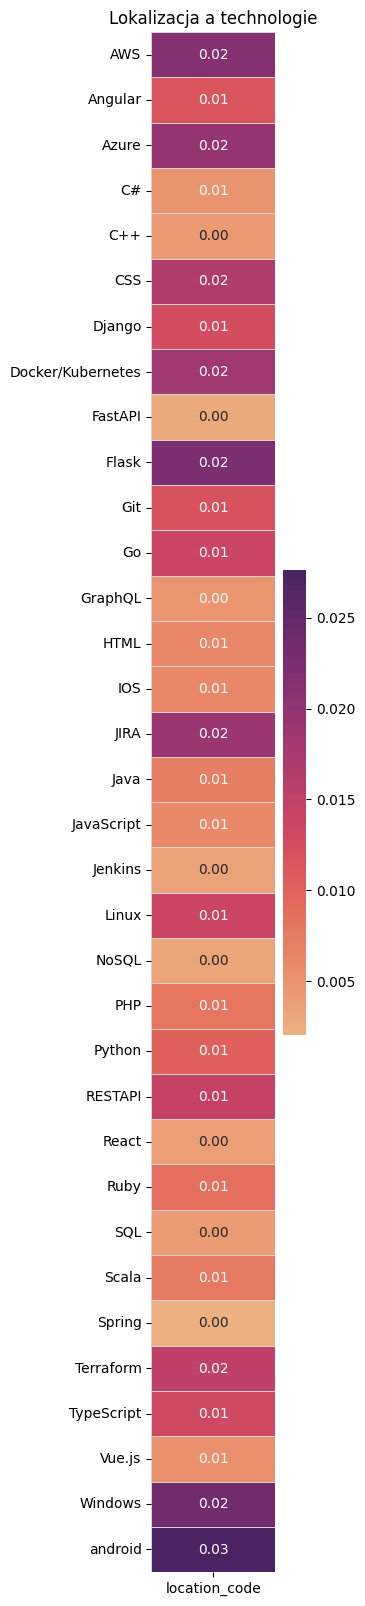

In [404]:
corr = data[["location_code"] + list(techs.columns)].corr()
corr = corr.abs()
corr = corr.loc[techs.columns, ["location_code"]]
create_corr_plot(corr, "Lokalizacja a technologie", size=(2, 20))

# Przewidywanie zarobków na podstawie technologii

Proces znaczniemy od napisania funckji, która będzie filtrować dane na podstawie kilku rzeczy:
- technologii
- lokalizacji
- doświadczenia

In [405]:
def filter_data(data, tech_stack=[], location=None, exp=None, other_col=[]):
    # Wybranie odpowiednich kolumn z doświadczeniem
    res = data
    if exp is not None:
        exp_code = exp_encoder.transform([exp])[0]
        res = data[data["experience_code"] == exp_code]

    if location is not None:
        # Wybranie odpowiednich kolumn z lokalizacją
        location_code = location_encoder.transform([location])[0]
        res = res[res["location_code"] == location_code]
    
    # Wybranie wierszy, które mają 1 dla kolumn w tech_stack
    if tech_stack != []:
        for tech in tech_stack:
            res = res[res[tech] == 1]
    else:
        tech_stack = data.loc[:, "AWS": "android"].columns.tolist()

    columns_to_keep = tech_stack + ["avg_b2b", "avg_uop", "operating_mode_code", "experience_code", "location_code"] + other_col 
    return res[columns_to_keep]


# Podział danych na oferty pracy uop i b2b

Kolejnym krokiem jest podział danych na oferty pracy uop i b2b oraz usunięcie nie potrzebnych kolumn w zalezności od
kontraktu.

In [406]:
def prepare_data_sets(tech_stack):
    filtered_data_b2b = filter_data(data[data["min_b2b"]>0], tech_stack=tech_stack)
    filtered_data_uop = filter_data(data[data["min_uop"]>0], tech_stack=tech_stack)
    return filtered_data_b2b.drop(columns=["avg_uop"]), filtered_data_uop.drop(columns=["avg_b2b"])

# Przyogowanie danych do modelu

`Features`: to są nasze dane wejściowe, które będą używane do przewidywania zarobków.

_początkowo miały to być tylko technologie, ale stwierdziłem, ze lepiej bardziej rozwinąć model_

`Target`: to są nasze dane wyjściowe, które chcemy przewidzieć.

Zwracamy dane do trenowania modelu oraz dane do testowania modelu. Zamierzam przetestować 
dla `test_size=0.2` oraz `test_size=0.4` i zobaczyć jaki podział jest lepszy.

In [407]:
def prepare_test_train_sets(data, value_to_predict: str, test_size: float=0.2):
    features = data.drop(columns=[value_to_predict], axis=1)
    target = data[value_to_predict]
    x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=test_size,random_state=42)
    return x_train, x_test, y_train, y_test
  

# Przygotowanie modeli

Wybrałem Regresje Liniową, Las losowy i drzewko decyzji.

**Dlaczego?**

- Regresja liniowa: jest to najprostszy model regresji, który zakłada liniową zależność między zmiennymi i pojawiła się na zajęciach.

- Random Forest: podobno skuteczny model (z polecenia znajomego), który jest złożeniem wielu drzew decyzyjnych.

- Drzewo decyzyjne: jest to najprostszy model, który zakłada, że dane są liniowe.


Nie wykluczam, ze będę testował inne modele, ale na razie zacznę od tych trzech.

Inne modele, które mogę przetestować:

- Lasso
- Ridge
- ElasticNet

In [432]:
models_to_tune = {
    'Linear_Regression':{
        'model':LinearRegression(),
        'params':{
            
        }
    },
    'Decision_Tree':{
        'model':DecisionTreeRegressor(),
        'params':{
            'max_depth':[2,4,6,8,10],
            'random_state':[0,42],
            'min_samples_split':[2,5,10,20]
        }
    },
    'Random_Forest':{
        'model':RandomForestRegressor(n_estimators=20),
        'params':{
            'n_estimators':[10,30,20,50,80]
        }
    },
    'Ridge':{
        'model':Ridge(alpha=.1),
        'params':{
            'alpha':[0.1,0.5,1,2,5,10]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 0.5, 1, 2, 5, 10]
        }
    }
}

In [409]:
# Hyper parameter tuning through grid search cv
from sklearn.model_selection import GridSearchCV


def tune_models(x_train, y_train):
    score = []

    for name, value in models_to_tune.items():
        clf = GridSearchCV(value['model'], value['params'], cv=5, scoring='neg_mean_squared_error')
        clf.fit(x_train, y_train)

        score.append({
            'Model': name,
            'Params': clf.best_params_,
            'MSE(-ve)': clf.best_score_
        })
    pd.DataFrame(score).to_csv("models_tuning.csv", index=False)

In [410]:
# # Definiuj słownik do przechowywania parametrów dla każdego modelu
# data = pd.read_csv('models_tuning.csv')

# model_params = {}

# # Pętla po każdym wierszu danych
# for index, row in data.iterrows():
#     model_name = row['Model']
#     params = eval(row['Params'])  # Zamień string na słownik
#     model_params[model_name] = params

# # Pobierz parametry dla konkretnych modeli
# n_estimators = model_params['Random_Forest']['n_estimators']

# alpha_ridge = model_params['Ridge']['alpha']

# alpha_elastic = model_params['ElasticNet']['alpha']
# l1_ratio = model_params['ElasticNet']['l1_ratio']

# alpha_lasso = model_params['Lasso']['alpha']

# models = [
#     LinearRegression(), DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, random_state=random_state),
#     RandomForestRegressor(n_estimators=n_estimators), Ridge(alpha=alpha_ridge), ElasticNet(alpha=alpha_elastic, l1_ratio=l1_ratio),
#     Lasso(alpha=alpha_lasso)
# ]

In [452]:
def plot_salary_distribution(data, predicted_salaries, contract, test_size):
    # Nie bierzemy pod uwagę ofert, które nie dotyczą zarobków na danym rodzaju umowy
    if contract == "b2b":
        real_salaries = data[data["avg_b2b"] > 0]["avg_b2b"]
    else:
        real_salaries = data[data["avg_uop"] > 0]["avg_uop"]

    # bierzemy nazwy technologii (można przekazać rzeczy w parametrach, ale wolę tak)
    tech_stack = data.loc[:, :"avg_b2b"].columns[:-1].tolist()

    # informacje o parametrach
    city = location_encoder.inverse_transform([data["location_code"].iloc[0]])[0]
    exp = exp_encoder.inverse_transform([data["experience_code"].iloc[0]])[0]
    
    # Tworzymy nowy wykres
    plt.figure(figsize=(14, 6))

    # Krzywa gęstości dla rzeczywistych zarobków
    sns.kdeplot(real_salaries, color='blue', label=f"Rzeczywiste zarobki na {contract}")

    # Krzywa gęstości dla przewidywanych zarobków
    sns.kdeplot(predicted_salaries, color='orange', label=f"Przewidziane zarobki na {contract}")

    plt.title(f"Rozkład dla {exp}a w {city} znającego {', '.join(tech_stack)}")
    plt.xlabel("Zarobki (PLN)")
    plt.ylabel("Gęstość ofert")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"plots/wyniki/{1-test_size}&{test_size}/przewidywane_zarobki_dla_{exp.lower()}a_w_{city.lower()}_{"_".join(tech_stack).replace("/", "_")}.png")
    plt.show()


# Wybieramy najlepszy model

Tutaj to zalezy od danych wejściowych, czasami zwraca Regresje Liniową, a czasami Random Forest.

In [421]:
def get_best_model(models, x_train, x_test, y_train, y_test, short=True):
    """
    Wybiera najlepszy model na podstawie danych treningowych i testowych.

    Parameters:
    models (dict): Słownik modeli z ich parametrami do tuningu.
    x_train (DataFrame): Dane treningowe.
    x_test (DataFrame): Dane testowe.
    y_train (Series): Docelowe wartości treningowe.
    y_test (Series): Docelowe wartości testowe.
    short (bool): Flaga do kontroli wyświetlania szczegółowych metryk.

    Returns:
    best_model: Najlepszy model na podstawie wskaźnika R^2.
    """
    
    def eval_model(model, x_train, x_test, y_train, y_test):
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
        y_pred = model.predict(x_test)
        metrics = {
            'Mean Squared Error': mean_squared_error(y_test, y_pred).round(2),
            'Mean Absolute Error': mean_absolute_error(y_test, y_pred).round(2),
            'Root Mean Squared Error': np.sqrt(mean_squared_error(y_test, y_pred).round(2)),
            'R^2 Score': r2_score(y_test, y_pred)
        }
        
        return score, metrics

    best_score = float('-inf')
    best_model = None
    best_metrics = None

    # tune_models(x_train, y_train)
    for model in models.values():
        model = model['model']
        score, metrics = eval_model(model, x_train, x_test, y_train, y_test)
        if score > best_score:
            best_score = score
            best_model = model
            best_metrics = metrics
        if not short:
            print(f'Przetwarzany model: {model}')
            for metric_name, metric_value in metrics.items():
                print(f"{metric_name} : {metric_value}")
            print()
            

    if short and best_metrics:
        print(f'Wybrany model: {best_model.__class__.__name__}')
        for metric_name, metric_value in best_metrics.items():
            print(f"{metric_name} : {metric_value}")

    return best_model

# Sklejenie wszystkich kroków w jedno

In [450]:
def predict_salary(models, **params):
    non_zero_b2b, non_zero_uop = prepare_data_sets(tech_stack=params["tech_stack"])
    
    def choose_contract(contract):
        if contract.lower() == "b2b":
            return prepare_test_train_sets(non_zero_b2b, "avg_b2b", params["test_size"])
        else:
            return prepare_test_train_sets(non_zero_uop, "avg_uop", params["test_size"])
        
    x_train, x_test, y_train, y_test = choose_contract(params["contract"])
    
    # uczymy model
    best_model = get_best_model(models, x_train, x_test, y_train, y_test, short=False)
    print("HALLLO ", best_model.__class__.__name__)

    # bierzemy dane juz z całego zbioru
    new_data1 = filter_data(data, location=params["location"], exp=params["exp"], tech_stack=params["tech_stack"])
    predicted_salaries = best_model.predict(new_data1.drop(columns=["avg_b2b", "avg_uop"]))
    predicted_mean_salary = predicted_salaries.mean().round(2)
    print(f"Przewidywane zarobki dla {params['exp']}a znającego {params['tech_stack']} w lokalizacji {params['location']} na umowie {params['contract']} to: {predicted_mean_salary} PLN\n")
    
    plot_salary_distribution(new_data1, predicted_salaries, params["contract"], params["test_size"])


# Przykładowe dane, gdzie chcemy przewidzieć zarobki

Opis inputu:

- `location`: Miasto gdzie chcemy pracować

- `experience`: Doświadczenie w 3 kategoriach: junior, mid, senior

- `technologies`: Technologie, które znamy, jako lista

- `contract`: Typ kontraktu, który nas interesuje

- `test_size`: Rozmiar testowy, który chcemy użyć do trenowania modelu

Przetwarzany model: LinearRegression()
Mean Squared Error : 28422749.87
Mean Absolute Error : 4358.93
Root Mean Squared Error : 5331.299079023798
R^2 Score : 0.42382731380909777

Przetwarzany model: DecisionTreeRegressor()
Mean Squared Error : 28253357.1
Mean Absolute Error : 4307.33
Root Mean Squared Error : 5315.388706388273
R^2 Score : 0.42726116476055165

Przetwarzany model: RandomForestRegressor(n_estimators=20)
Mean Squared Error : 28121996.91
Mean Absolute Error : 4308.76
Root Mean Squared Error : 5303.017717300217
R^2 Score : 0.429924037053277

Przetwarzany model: Ridge(alpha=0.1)
Mean Squared Error : 28422322.4
Mean Absolute Error : 4358.92
Root Mean Squared Error : 5331.258988269094
R^2 Score : 0.4238359792017564

Przetwarzany model: Lasso()
Mean Squared Error : 28422009.47
Mean Absolute Error : 4358.85
Root Mean Squared Error : 5331.229639585975
R^2 Score : 0.4238423228604381

HALLLO  RandomForestRegressor
      Python  operating_mode_code  experience_code  location_code
129

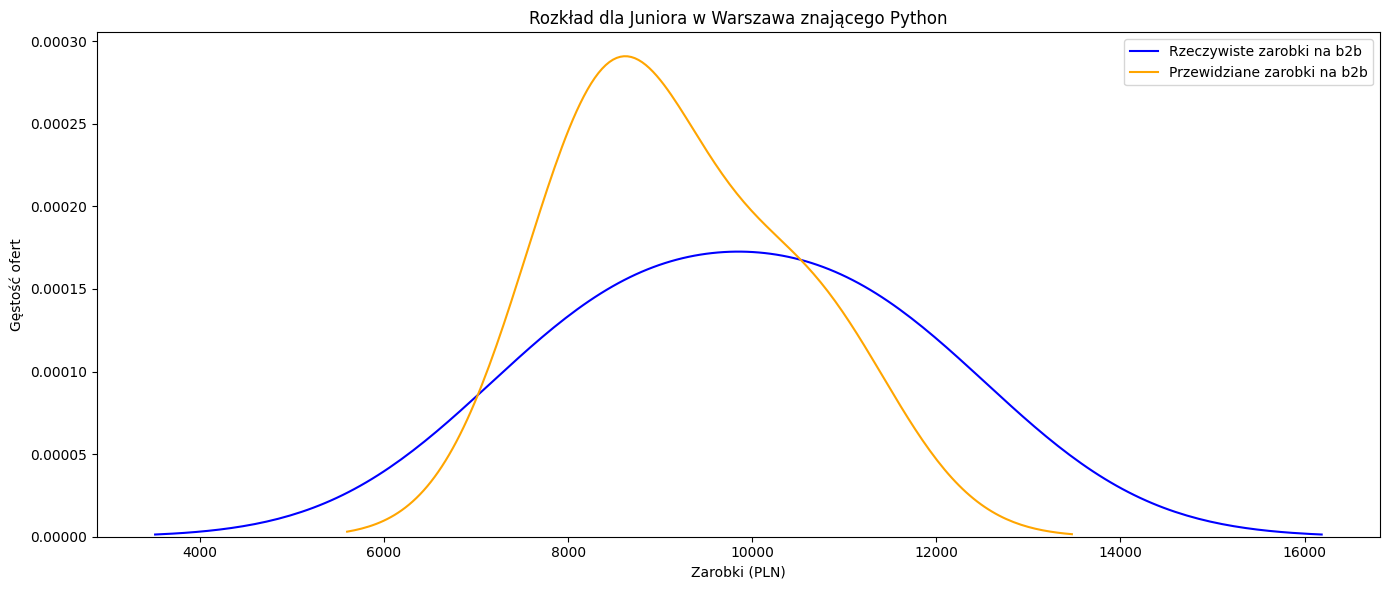

Przetwarzany model: LinearRegression()
Mean Squared Error : 13221438.39
Mean Absolute Error : 2919.54
Root Mean Squared Error : 3636.1295892748376
R^2 Score : 0.482328553069861

Przetwarzany model: DecisionTreeRegressor()
Mean Squared Error : 21276698.63
Mean Absolute Error : 3431.44
Root Mean Squared Error : 4612.66719263378
R^2 Score : 0.16693335145334853

Przetwarzany model: RandomForestRegressor(n_estimators=20)
Mean Squared Error : 17907518.24
Mean Absolute Error : 3131.32
Root Mean Squared Error : 4231.727571571686
R^2 Score : 0.2988500487042992

Przetwarzany model: Ridge(alpha=0.1)
Mean Squared Error : 13213875.66
Mean Absolute Error : 2918.68
Root Mean Squared Error : 3635.0894982104637
R^2 Score : 0.4826246637289875

Przetwarzany model: Lasso()
Mean Squared Error : 13219274.21
Mean Absolute Error : 2919.21
Root Mean Squared Error : 3635.831983191743
R^2 Score : 0.48241328891639534

HALLLO  Ridge
      JavaScript  React  operating_mode_code  experience_code  location_code
1039 

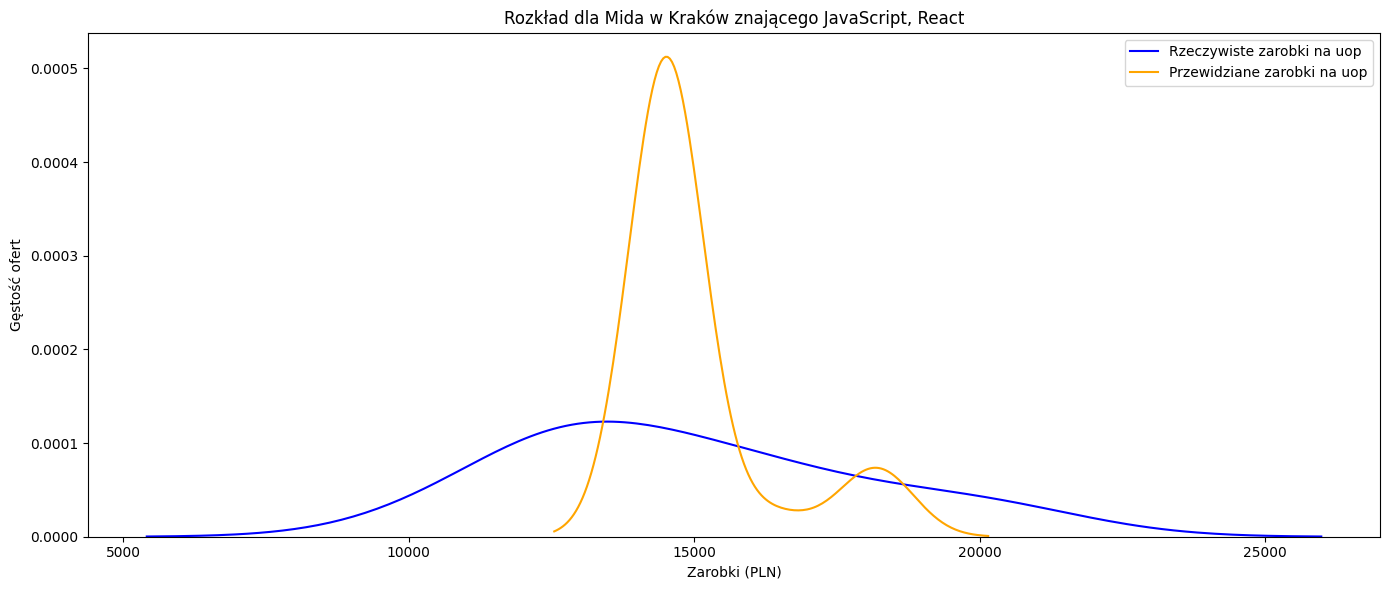

Przetwarzany model: LinearRegression()
Mean Squared Error : 11084299.37
Mean Absolute Error : 2678.04
Root Mean Squared Error : 3329.309143050552
R^2 Score : 0.6751694366386829

Przetwarzany model: DecisionTreeRegressor()
Mean Squared Error : 10681171.68
Mean Absolute Error : 2605.54
Root Mean Squared Error : 3268.206186886011
R^2 Score : 0.6869832815249849

Przetwarzany model: RandomForestRegressor(n_estimators=20)
Mean Squared Error : 10407118.7
Mean Absolute Error : 2594.23
Root Mean Squared Error : 3226.0066180961253
R^2 Score : 0.6950145320857477

Przetwarzany model: Ridge(alpha=0.1)
Mean Squared Error : 11091505.44
Mean Absolute Error : 2678.65
Root Mean Squared Error : 3330.391184230465
R^2 Score : 0.6749582593695012

Przetwarzany model: Lasso()
Mean Squared Error : 11085643.78
Mean Absolute Error : 2678.07
Root Mean Squared Error : 3329.511042180218
R^2 Score : 0.6751300380731887

HALLLO  RandomForestRegressor
      Docker/Kubernetes  AWS  operating_mode_code  experience_code  

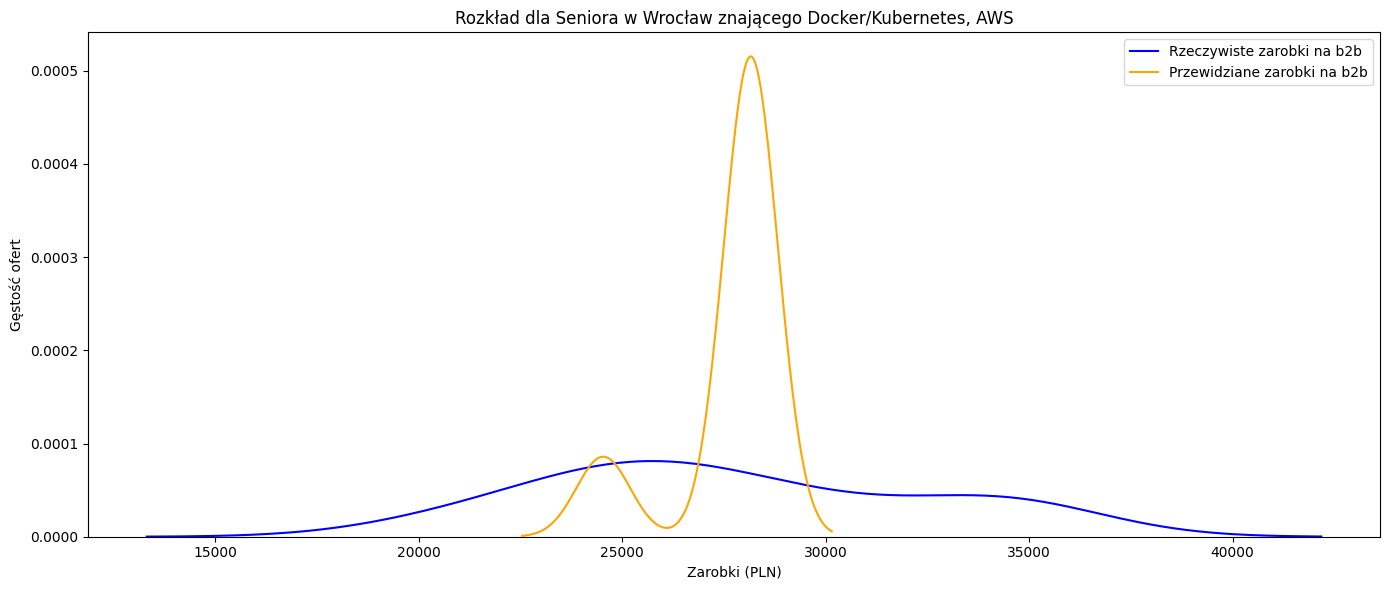

In [455]:
test1 = {
    "location": "Warszawa",
    "exp": "Junior",
    "test_size": 0.2,
    "contract": "b2b",
    "tech_stack": ["Python"]
}

test2 = {
    "location": "Kraków",
    "exp": "Mid",
    "test_size": 0.2,
    "contract": "uop",
    "tech_stack": ["JavaScript", "React"]
}

test3 = {
    "location": "Wrocław",
    "exp": "Senior",
    "test_size": 0.2,
    "contract": "b2b",
    "tech_stack": ["Docker/Kubernetes", "AWS"]
}

predict_salary(models_to_tune, **test1)
predict_salary(models_to_tune, **test2)
predict_salary(models_to_tune, **test3)


# Analiza wyników dla przykładowych danych

Przetwarzany model: LinearRegression()
Mean Squared Error : 29050483.53
Mean Absolute Error : 4406.48
Root Mean Squared Error : 5389.850047079232
R^2 Score : 0.4096943109533664

Przetwarzany model: DecisionTreeRegressor()
Mean Squared Error : 29520117.74
Mean Absolute Error : 4434.43
Root Mean Squared Error : 5433.24191804488
R^2 Score : 0.4001513460858793

Przetwarzany model: RandomForestRegressor(n_estimators=20)
Mean Squared Error : 29210648.93
Mean Absolute Error : 4417.47
Root Mean Squared Error : 5404.687681078343
R^2 Score : 0.4064397508050068

Przetwarzany model: Ridge(alpha=0.1)
Mean Squared Error : 29050015.21
Mean Absolute Error : 4406.39
Root Mean Squared Error : 5389.806602281756
R^2 Score : 0.4097038271937392

Przetwarzany model: Lasso()
Mean Squared Error : 29049387.82
Mean Absolute Error : 4406.36
Root Mean Squared Error : 5389.748400435776
R^2 Score : 0.4097165758027773

HALLLO  Lasso
Przewidywane zarobki dla Juniora znającego ['Python'] w lokalizacji Warszawa na umowi

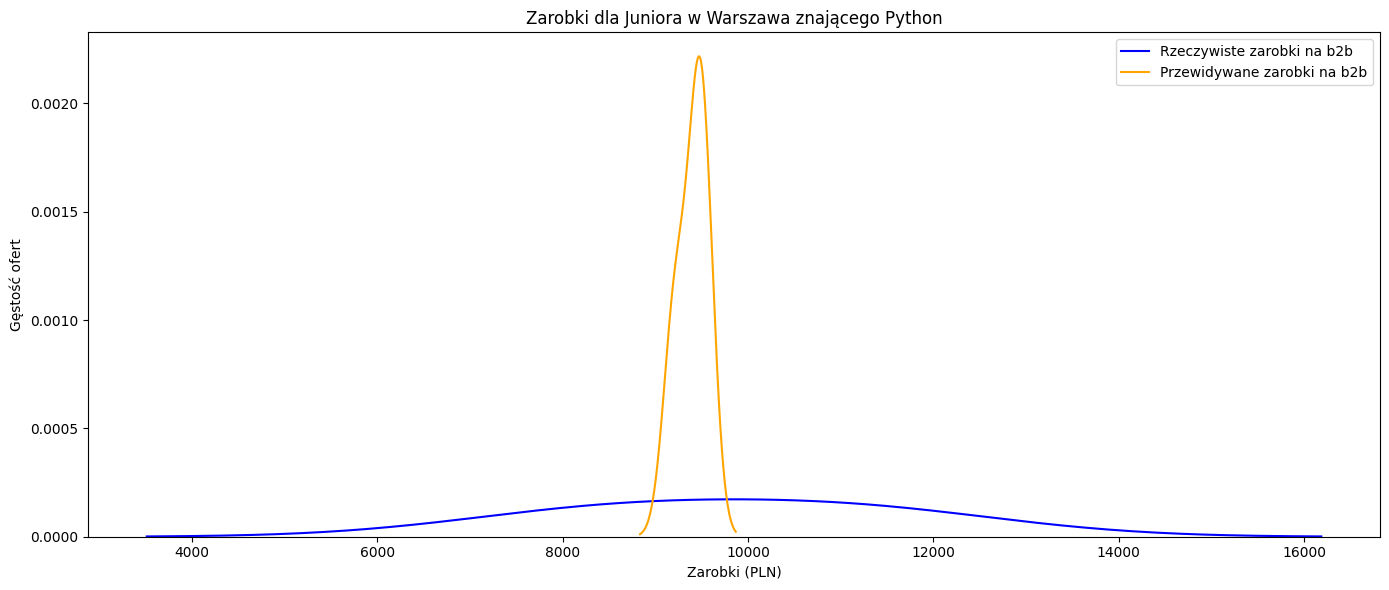

Przetwarzany model: LinearRegression()
Mean Squared Error : 17512382.62
Mean Absolute Error : 3014.49
Root Mean Squared Error : 4184.779877126155
R^2 Score : 0.421255219263851

Przetwarzany model: DecisionTreeRegressor()
Mean Squared Error : 21206971.44
Mean Absolute Error : 3442.39
Root Mean Squared Error : 4605.102761068421
R^2 Score : 0.2991573849457221

Przetwarzany model: RandomForestRegressor(n_estimators=20)
Mean Squared Error : 18610952.15
Mean Absolute Error : 3251.63
Root Mean Squared Error : 4314.041278198436
R^2 Score : 0.3849499721906052

Przetwarzany model: Ridge(alpha=0.1)
Mean Squared Error : 17503667.86
Mean Absolute Error : 3014.1
Root Mean Squared Error : 4183.738502822565
R^2 Score : 0.4215432227281408

Przetwarzany model: Lasso()
Mean Squared Error : 17512097.61
Mean Absolute Error : 3014.5
Root Mean Squared Error : 4184.745823822517
R^2 Score : 0.4212646382331072

HALLLO  Ridge
Przewidywane zarobki dla Mida znającego ['JavaScript', 'React'] w lokalizacji Kraków na

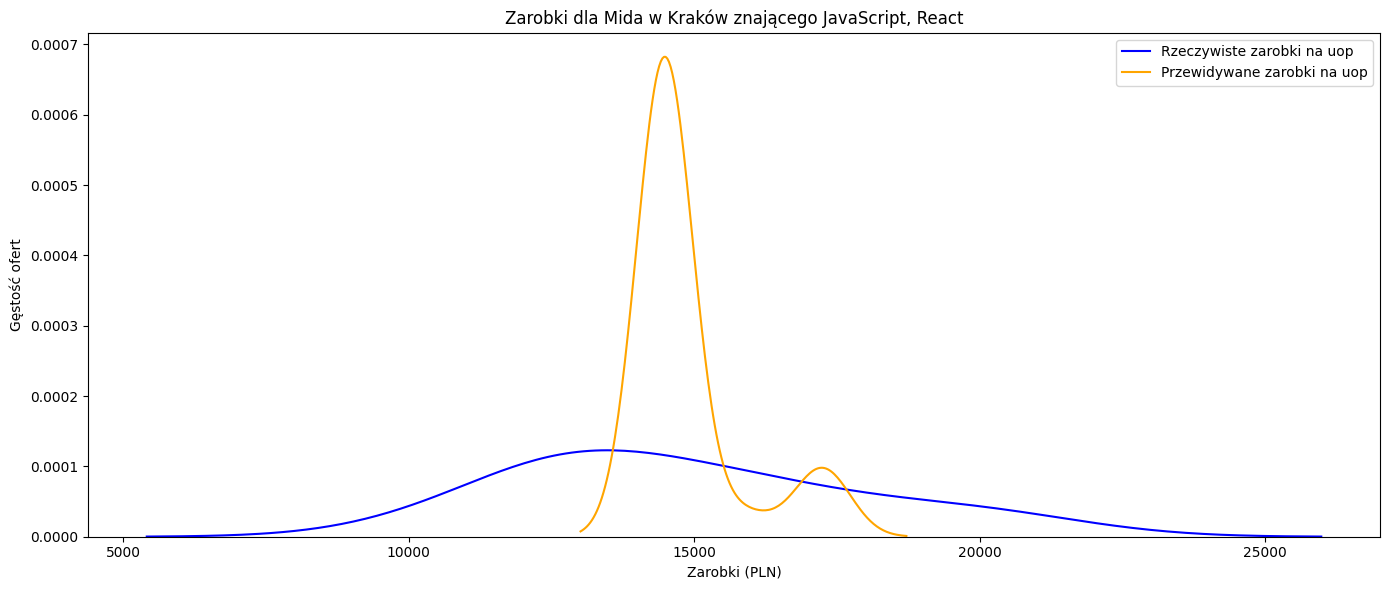

Przetwarzany model: LinearRegression()
Mean Squared Error : 10035694.55
Mean Absolute Error : 2466.69
Root Mean Squared Error : 3167.91643671357
R^2 Score : 0.7058661792547817

Przetwarzany model: DecisionTreeRegressor()
Mean Squared Error : 10593012.16
Mean Absolute Error : 2564.23
Root Mean Squared Error : 3254.690793301262
R^2 Score : 0.6895318879447312

Przetwarzany model: RandomForestRegressor(n_estimators=20)
Mean Squared Error : 10042038.81
Mean Absolute Error : 2513.25
Root Mean Squared Error : 3168.917608584988
R^2 Score : 0.7056802367009452

Przetwarzany model: Ridge(alpha=0.1)
Mean Squared Error : 10036240.1
Mean Absolute Error : 2467.61
Root Mean Squared Error : 3168.0025410343346
R^2 Score : 0.7058501896718694

Przetwarzany model: Lasso()
Mean Squared Error : 10036562.26
Mean Absolute Error : 2466.89
Root Mean Squared Error : 3168.0533865451193
R^2 Score : 0.7058407477129465

HALLLO  LinearRegression
Przewidywane zarobki dla Seniora znającego ['Docker/Kubernetes', 'AWS'] w

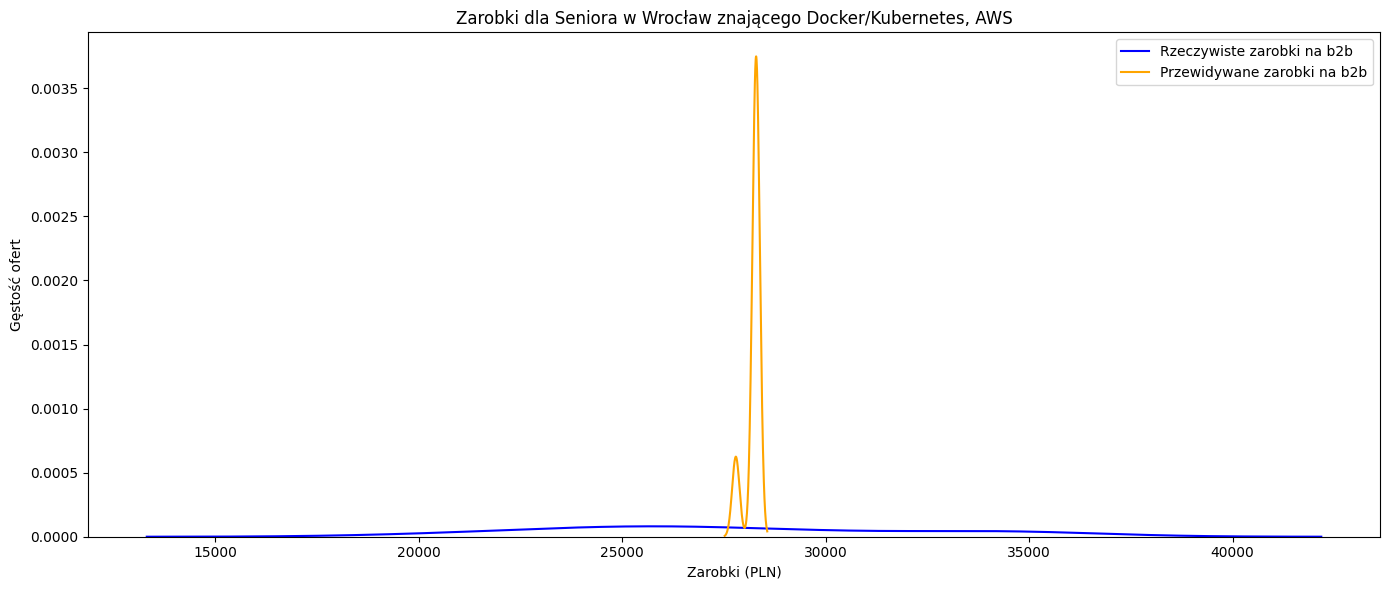

In [441]:
test1 = {
    "location": "Warszawa",
    "exp": "Junior",
    "test_size": 0.4,
    "contract": "b2b",
    "tech_stack": ["Python"]
}

test2 = {
    "location": "Kraków",
    "exp": "Mid",
    "test_size": 0.4,
    "contract": "uop",
    "tech_stack": ["JavaScript", "React"]
}

test3 = {
    "location": "Wrocław",
    "exp": "Senior",
    "test_size": 0.4,
    "contract": "b2b",
    "tech_stack": ["Docker/Kubernetes", "AWS"]
}

predict_salary(models_to_tune, **test1)
predict_salary(models_to_tune, **test2)
predict_salary(models_to_tune, **test3)